In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from razdel import tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, \
precision_recall_curve, confusion_matrix
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.test.utils import datapath
import re
import pymorphy2
import itertools
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
news = pd.read_csv("articles.csv")
news.head()

,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...
3,4898,Главный тренер «Кубани» Юрий Красножан прокомм...
4,4899,Решением попечительского совета владивостокско...


In [3]:
users = pd.read_csv("users_articles.csv")
users.head()

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"


In [4]:
stopwords_ru = stopwords.words('russian')
morph = pymorphy2.MorphAnalyzer()
len(stopwords_ru)

151

In [5]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
    stopwords_ru += additional_stopwords
len(stopwords_ru)

776

In [6]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopwords_ru] # [6]
    
    return words_lem_without_stopwords

In [7]:
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

In [8]:
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

In [9]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [10]:

# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

In [11]:

# Save model to disk.
temp_file = datapath("model.lda")
#lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [12]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(3, 0.032909155),
 (4, 0.051683523),
 (7, 0.20339423),
 (14, 0.03617413),
 (18, 0.21218598),
 (20, 0.031425416),
 (22, 0.4131731)]

In [13]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: рак пенсия турецкий турция мозг противник ресторан
topic_1: статья украина писать украинский nn закон район
topic_2: научный рост фонд проект станция программа новый
topic_3: товар физика производить миссия оплата вина обвинить
topic_4: земля проект университет строительство nn новый москва
topic_5: nn путин владимир россия российский москва nnn
topic_6: банк экономика экономический остров министерство рф директор
topic_7: гражданин сотрудник погибнуть власть область орган россия
topic_8: взрыв лётчик су пилот пропасть гагарин выбросить
topic_9: британский свет обращение восток великобритания умереть лондон
topic_10: смерть лечение обнаружить методика площадь передовой сергеев
topic_11: рынок цена наука население рубль россия российский
topic_12: военный операция система объект управление расчёт налог
topic_13: россия российский ракета сша украина nn граница
topic_14: снижение годовой вино звание высота мотив стандарт
topic_15: белоруссия век законодательство белорусский ii ег

In [14]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [15]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.107646,0.000000,0.000000,0.066402,0.730571,0.000000,0.000000,...,0.0,0.00000,0.000000,0.053156,0.0,0.000000,0.034563,0.000000,0.000000,0.0
1,4896,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.415466,0.301786,...,0.0,0.00000,0.000000,0.259584,0.0,0.000000,0.000000,0.000000,0.000000,0.0
2,4897,0.0,0.0,0.000000,0.032909,0.051610,0.000000,0.000000,0.203444,0.000000,...,0.0,0.00000,0.000000,0.212186,0.0,0.031434,0.000000,0.413186,0.000000,0.0
3,4898,0.0,0.0,0.000000,0.000000,0.073223,0.244979,0.000000,0.000000,0.000000,...,0.0,0.01959,0.000000,0.043866,0.0,0.000000,0.000000,0.541835,0.066719,0.0
4,4899,0.0,0.0,0.000000,0.000000,0.216412,0.000000,0.412753,0.000000,0.000000,...,0.0,0.00000,0.254946,0.090442,0.0,0.000000,0.000000,0.000000,0.000000,0.0


In [16]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [17]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.        , 0.17248996,
       0.20798661, 0.        , 0.18014763, 0.02036504, 0.        ,
       0.        , 0.07465059, 0.        , 0.03519667, 0.06721202,
       0.04962805, 0.        , 0.18145877, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [18]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list, stat):
    stat_type = [np.mean, np.median, np.max]
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = stat_type[stat](user_vector, 0)
    return user_vector

In [20]:
get_user_embedding(user_articles_list,1)

array([0.        , 0.06453635, 0.        , 0.        , 0.01514936,
       0.13336127, 0.        , 0.02962896, 0.        , 0.        ,
       0.        , 0.07355906, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.17649899, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [21]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, 1), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.000000,0.000000,0.0,0.112987,0.109248,0.000000,0.084198,0.010183,...,0.024814,0.0,0.078098,0.0,0.017840,0.000000,0.000000,0.000000,0.0,0.0
1,u108690,0.0,0.078976,0.000000,0.0,0.028712,0.122173,0.011702,0.085075,0.000000,...,0.000000,0.0,0.103102,0.0,0.012243,0.031970,0.008247,0.010900,0.0,0.0
2,u108339,0.0,0.067197,0.028256,0.0,0.034018,0.072726,0.025436,0.234015,0.000000,...,0.000000,0.0,0.122170,0.0,0.023648,0.047058,0.000000,0.014777,0.0,0.0


In [22]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [23]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.000000,0.000000,0.0,0.112987,0.109248,0.000000,0.084198,0.010183,...,0.0,0.078098,0.0,0.017840,0.000000,0.000000,0.000000,0.0,0.0,0
1,u108690,0.0,0.078976,0.000000,0.0,0.028712,0.122173,0.011702,0.085075,0.000000,...,0.0,0.103102,0.0,0.012243,0.031970,0.008247,0.010900,0.0,0.0,1
2,u108339,0.0,0.067197,0.028256,0.0,0.034018,0.072726,0.025436,0.234015,0.000000,...,0.0,0.122170,0.0,0.023648,0.047058,0.000000,0.014777,0.0,0.0,1


In [24]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [25]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [26]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.1234083 , 0.04579012, 0.50736411, 0.26088601, 0.05331818,
       0.06814319, 0.12441664, 0.01144987, 0.06051228, 0.24127417])

In [27]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.747240, F-Score=nan, Precision=0.000, Recall=0.000


In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1755    0]
 [ 245    0]]


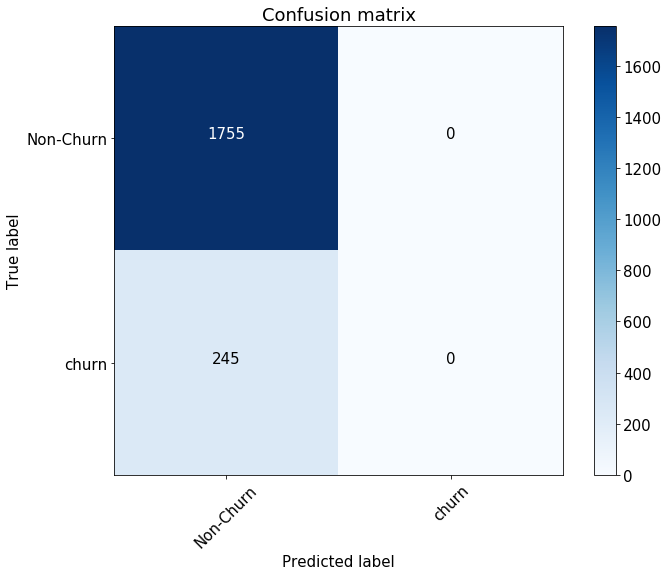

In [29]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [30]:
roc_auc_score(y_test, preds)

0.9577324263038548

In [31]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x,2), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.309161,0.148692,0.029306,0.447946,0.343872,0.069856,0.315009,0.063416,...,0.101467,0.027664,0.238578,0.000000,0.082532,0.408915,0.000000,0.032923,0.151926,0.0
1,u108690,0.000000,0.161577,0.092563,0.107498,0.056902,0.302323,0.070487,0.399721,0.000000,...,0.000000,0.000000,0.222880,0.000000,0.037547,0.202251,0.084219,0.158601,0.000000,0.0
2,u108339,0.019224,0.098285,0.054221,0.052345,0.153287,0.176782,0.083001,0.377772,0.019249,...,0.000000,0.021583,0.488239,0.014694,0.174645,0.080966,0.000000,0.043373,0.000000,0.0


In [32]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.309161,0.148692,0.029306,0.447946,0.343872,0.069856,0.315009,0.063416,...,0.027664,0.238578,0.000000,0.082532,0.408915,0.000000,0.032923,0.151926,0.0,0
1,u108690,0.000000,0.161577,0.092563,0.107498,0.056902,0.302323,0.070487,0.399721,0.000000,...,0.000000,0.222880,0.000000,0.037547,0.202251,0.084219,0.158601,0.000000,0.0,1
2,u108339,0.019224,0.098285,0.054221,0.052345,0.153287,0.176782,0.083001,0.377772,0.019249,...,0.021583,0.488239,0.014694,0.174645,0.080966,0.000000,0.043373,0.000000,0.0,1


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [34]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [35]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.18765169, 0.00663739, 0.85968523, 0.04493207, 0.02372359,
       0.04319228, 0.03047558, 0.00251408, 0.0084947 , 0.39126978])

In [36]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.355260, F-Score=0.797, Precision=0.816, Recall=0.780


Confusion matrix, without normalization
[[1712   43]
 [  55  190]]


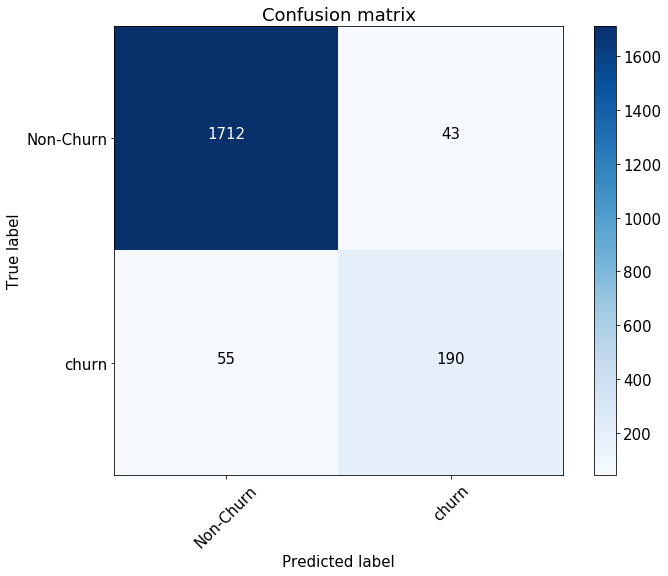

In [37]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [38]:
roc_auc_score(y_test, preds)

0.9709890109890109